# Spectrotemporal receptive field estimation and linear models

Last edited March 2019 by Liberty Hamilton

This jupyter notebook tutorial will explain how to calculate spectrotemporal receptive field models and time-delayed linear models in general. There are a number of papers using related methods, some of which are listed here:

**References:**

* Aertsen & Johannesma (1981). The spectro-temporal receptive field.  Biological Cybernetics 42, 133-143. http://hearingbrain.org/docs/AertsenSTRF_1981.pdf
* Theunissen, David, Singh et al. (2001). Estimating spatio-temporal receptive fields of auditory and visual neurons from their responses to natural stimuli. Network 2001, 12:3 289-316. http://www.maths.tcd.ie/~mnl/store/TheunissenEtAl2001a.pdf
* Wu, David, Gallant (2006). Complete functional characterization of sensory neurons by system identification.  Annu Rev Neurosci 29: 477-505. http://suns.mit.edu/2006.Wu.David.Gallant.pdf

## What is a spectrotemporal receptive field?
A spectrotemporal receptive field is a linear filter that describes which spectrotemporal features of a stimulus will increase or decrease activity in a neuron/electrode/recording site.  

## Ridge regression (in general) ##

The goal of ridge regression is to find a linear transformation of your feature matrix, $X$, that best approximates your observed data, $Y$. The linear transformation takes the form of a weight matrix, $B$, such that $X B = Y$.

In ridge regression, $B$ is obtained by taking the ridge pseudoinverse of $X$ and multiplying it by $Y$ ($\hat{B} = X^+ Y$). To get the ridge pseudoinverse we first take the eigenvalue decomposition of $X$: $X = U S U^{-1}$. For a normal pseudoinverse we would just invert the singular values (forming the inverse matrix $D$ by taking $1/S$ for each entry in $S$), but for a ridge pseudoinverse we regularize the inverse using a ridge penalty, $\alpha$. Thus we use $D_i = \frac{S_i}{(S_i^2 + \alpha^2)}$. This fixes problems with very small singular values, which would get very large in the inverse and mess things up.  Thus,

$X=U S V^T$ (this is the SVD of $X$)

or

$X = V S^2 V^T$ (for eigenvalue decomposition)

$X^+ = V D U^T $, where

$D_i = \frac{S_i}{(S_i^2 + \alpha^2)}$

The key issue for doing ridge regression is choosing the right $\alpha$. For real-world data (which is autocorrelated and messy), this is usually done by testing many different possible values of a using cross validation. In cross validation the regression dataset is broken up into two parts, a training set and a test set. A separate weight matrix, $B$, is obtained for each value of a using the training set, and then that $B$ is used to predict the test set. 

Weight estimates: $\hat{B} = X^+ Y$

$\hat{B} = V D(\alpha) U^T Y$

New prediction:

$\begin{eqnarray}
\hat{Y_{\mbox{held out}}} &=& X_{\mbox{held out}}\hat{B}\\
&=& X_{\mbox{held out}} V D(\alpha) U^T Y\\
&=& (X_{\mbox{held out}} V) D(\alpha) (U^T Y)
\end{eqnarray}$

This process is usually repeated a few times for a few different selections of training and test set. Then the best $\alpha$ is selected based on how well each $\alpha$ could be used to predict the test set.  


## The tutorial!

To use your own data, you will need:

- Your stimulus matrix (time x features).  This might be a spectrogram (150,000 time points x 80 frequency bands, for example), or it might be a binary matrix for the presence/absence of phonemes or phonetic features (in that case, 150,000 time points x 59 phonemes). It could also be just one feature you want to test (e.g. pitch, so the stimulus would be 150,000 time points x 1 pitch channel).
- Your response matrix (time x electrodes).  
    - For ECoG, this is your preprocessed, z-scored high gamma analytic amplitude. It could also be theta power over time, delta power over time, etc.  Anything thats time x electrodes
    - For EEG, this could be the raw time series data, but should be after artifact rejection (eyeblinks, jaw clench, etc. are removed). It could also be the bandpassed data in any band of your choosing (e.g. delta, theta, alpha, beta, gamma)
- The file should also contain the sampling rate of the data as a variable "fs".

Sample data is included here from an ECoG participant (EC63), who was listening to sentences from the TIMIT database. You can also choose to load EEG data.


In [2]:
# Set up the notebook, import the libraries we need

%matplotlib inline
# Load the stimulus and response data
import scipy.io # For .mat files
import h5py # For loading hf5 files
import mne # For loading BrainVision files (EEG)
import numpy as np
from audio_tools import spectools, fbtools, phn_tools
from scipy.io import wavfile

import matplotlib.pyplot as plt # For plotting
from matplotlib import cm, rcParams

from ridge.utils import make_delayed, counter, save_table_file
from ridge.ridge import ridge_corr, bootstrap_ridge, eigridge_corr

# Get the data!

Here we will load in the data for either ECoG or EEG. The steps to get here will differ a bit depending on your preprocessing pipeline.

In [79]:
# Choose which of these data files to use
dataFile = 'data/sample_ECoG/sample_ecog_stimresp.hf5' # For ECoG
#dataFile = 'data/sample_EEG/EEG_P0008/ICA_Data/EEG_P0008_B1_Data Cache.vhdr' # For EEG
#dataFile = '/Volumes/research_projects/Hamilton/speechsong/EEG/EEG_P0007/ICA Data/EEG_P0007_B1_Data Cache.vhdr' # For EEG

print("Getting data from %s"%(dataFile))
if dataFile == 'data/sample_ECoG/sample_ecog_stimresp.hf5': 
    tf = h5py.File(dataFile) # Get the file
    stim = tf['audstim'][:] # Load the spectrogram matrix
    phnstim = tf['phnstim'][:] # Load the binary phoneme presence/absence matrix (can use as stim instead)
    resp = tf['resp'][:] # The response matrix
    fs = tf['fs'][:] # Sampling frequency of the neural data

if dataFile == '/Volumes/research_projects/Hamilton/speechsong/EEG/EEG_P0007/ICA Data/EEG_P0007_B1_Data Cache.vhdr':
    # Get the EEG data from the BrainVision file
    raw=mne.io.read_raw_brainvision(dataFile, preload=True)
    # Set the montage from the cap file provided by BrainVision that tells you where
    # each sensor is located on the head (for topomaps)
    raw.set_montage('/Volumes/research_projects/Hamilton/code/EEG_utils/AP-128.bvef')
    picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
    raw.set_eeg_reference(['TP9','TP10'])
    resp = raw.get_data(picks = picks).T
    fs = raw.info['sfreq']
    print(fs)
    
    # We have to get the audio from a different file...
    #audioFile = 'data/sample_EEG/EEG_P0008/Audio/EEG_P0008_B1_16kHz.wav'
    audioFile = '/Volumes/research_projects/Hamilton/speechsong/EEG/EEG_P0007/Audio/EEG_P0007_B1_16kHz.wav'
    
    print("Reading in audio file %s"%(audioFile))
    [audio_fs, w] = wavfile.read(audioFile)
    print("Sampling rate is %d"%(audio_fs))
    w=w.astype(np.float)
    steptime = 1./fs 
    # Normally nfilts = 80, but here we're doing 25 to make things tractable
    stim, freqs = spectools.make_mel_spectrogram(w, audio_fs, nfilts=25, steptime=steptime)
    stim = stim.T # Transpose so time is the first dimension
    
    # Sometimes due to resampling the stimulus and response matrices will be a few samples off,
    # so reduce the size of whichever one is larger
    time_diff = np.abs(stim.shape[0] - resp.shape[0])
    if time_diff > 3:
        warning("Shapes are not matched and are too far apart. Did you do something wrong with resampling?")
    else:
        print("Difference of %d samples"%(time_diff))
        min_len = np.min((stim.shape[0], resp.shape[0]))
        stim = stim[:min_len, :]
        resp = resp[:min_len, :]
    
nchans = resp.shape[1] # The number of channels (e.g. electrodes, neurons)

# Let's look at the dimensions of the stimulus matrix
print("Data file: %s"%(dataFile))
print("Data file", dataFile)
print("Stimulus is %d time points x %d features"%(stim.shape))
print("Response is %d time points x %d channels"%(resp.shape))

Getting data from data/sample_ECoG/sample_ecog_stimresp.hf5
Data file: data/sample_ECoG/sample_ecog_stimresp.hf5
Data file data/sample_ECoG/sample_ecog_stimresp.hf5
Stimulus is 100322 time points x 80 features
Response is 100322 time points x 256 channels


## Plot the stimulus and response

At this point, it's helpful to show what the stimuli and responses look like so we know what will go into our model.  You should also check that nothing is weird with your spectrograms, and that trials with artifacts have been removed.

In [80]:
# Run this if you have a Retina or high resolution display, otherwise comment out
%config InlineBackend.figure_format = 'retina' 

In [81]:
# Z-score the response
zs = lambda x: (x-x.mean(0))/x.std(0)

resp=zs(resp)


## Plot stimulus and response to see what they look like

These are the inputs to the STRF model

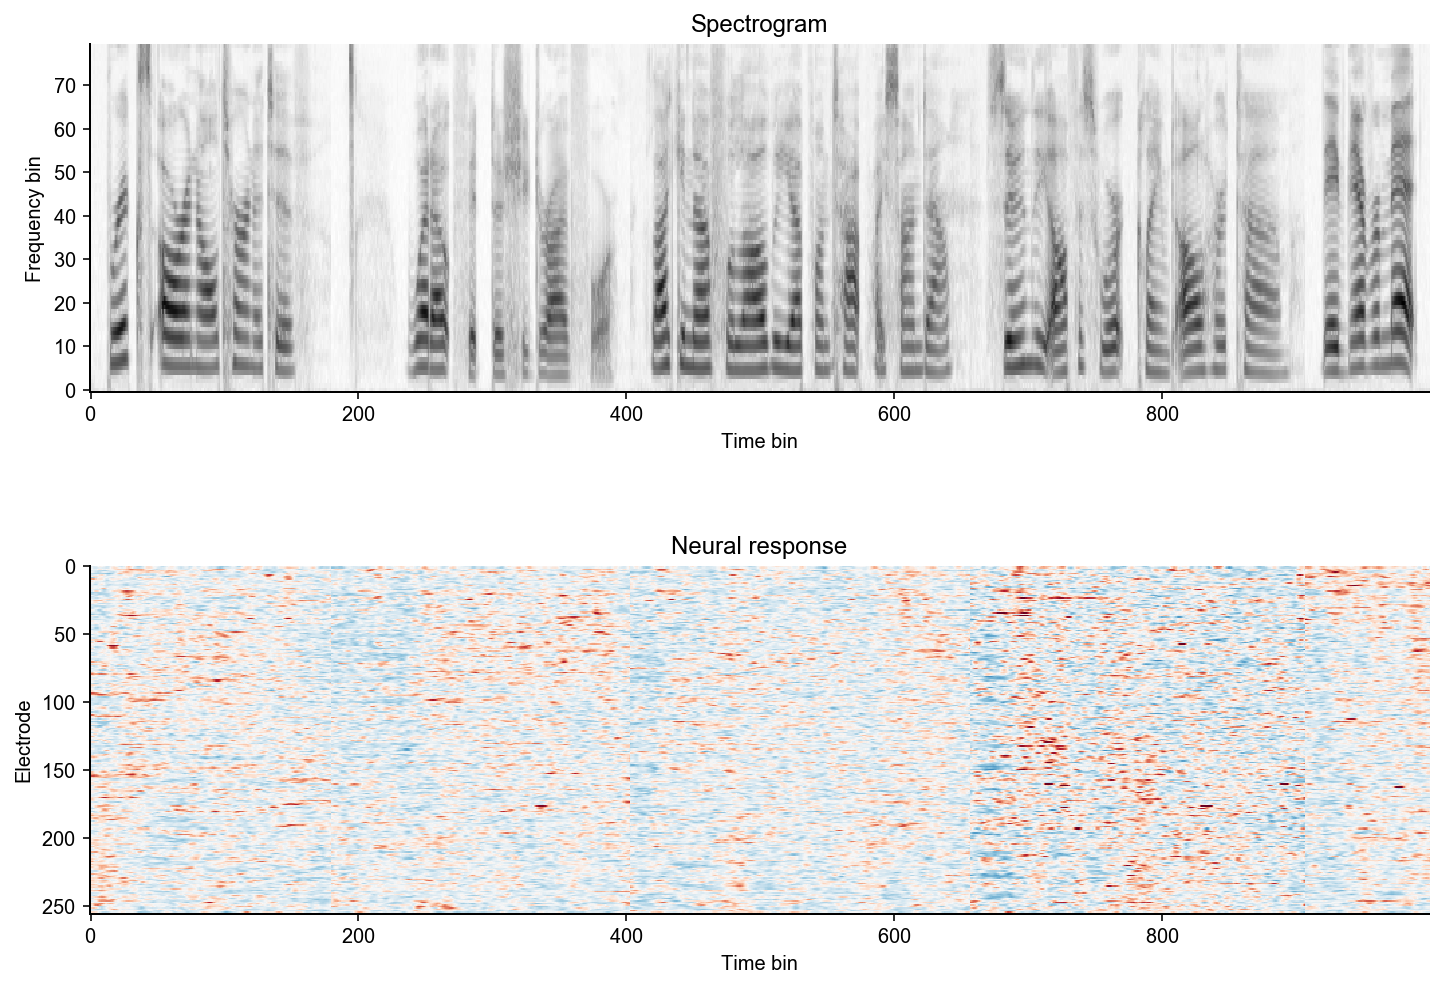

In [82]:
# Instead of plotting all ~100,000 time points, let's just plot a subset to get an idea
fig, axes = plt.subplots(figsize=(12,8)) # make a figure of size 12 x 8
ax = fig.add_subplot(2,1,1)
plt.imshow(stim[:1000,:].T, cmap = cm.Greys, aspect='auto') # I transposed the matrix so time is on the x axis
ax.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom

plt.xlabel('Time bin')
plt.ylabel('Frequency bin')
plt.title('Spectrogram')

plt.subplot(2,1,2)
if nchans>4: # For a large number of channels, show an image
    rmax = np.max(np.abs(resp))*0.5
    plt.imshow(resp[:1000,:].T, vmin=-rmax, vmax=rmax, cmap = cm.RdBu_r, aspect='auto', interpolation = 'none') 
    plt.ylabel('Electrode')
else: # For a small number of channels, plot the time series
    plt.plot(resp[:1000,:]) 
    plt.ylabel('Z')
plt.xlabel('Time bin')
plt.title('Neural response')

fig.subplots_adjust(hspace=.5) # Put some space between the plots for ease of viewing

# Set some parameters for this and future plots
rcParams['font.family'] = 'sans-serif'
rcParams['text.usetex'] = False
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10

#plt.savefig("sample_stimresp.pdf")

## Regression schematic

['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8', 'Aux1', 'STI 014']
[0]


(-6, 6)

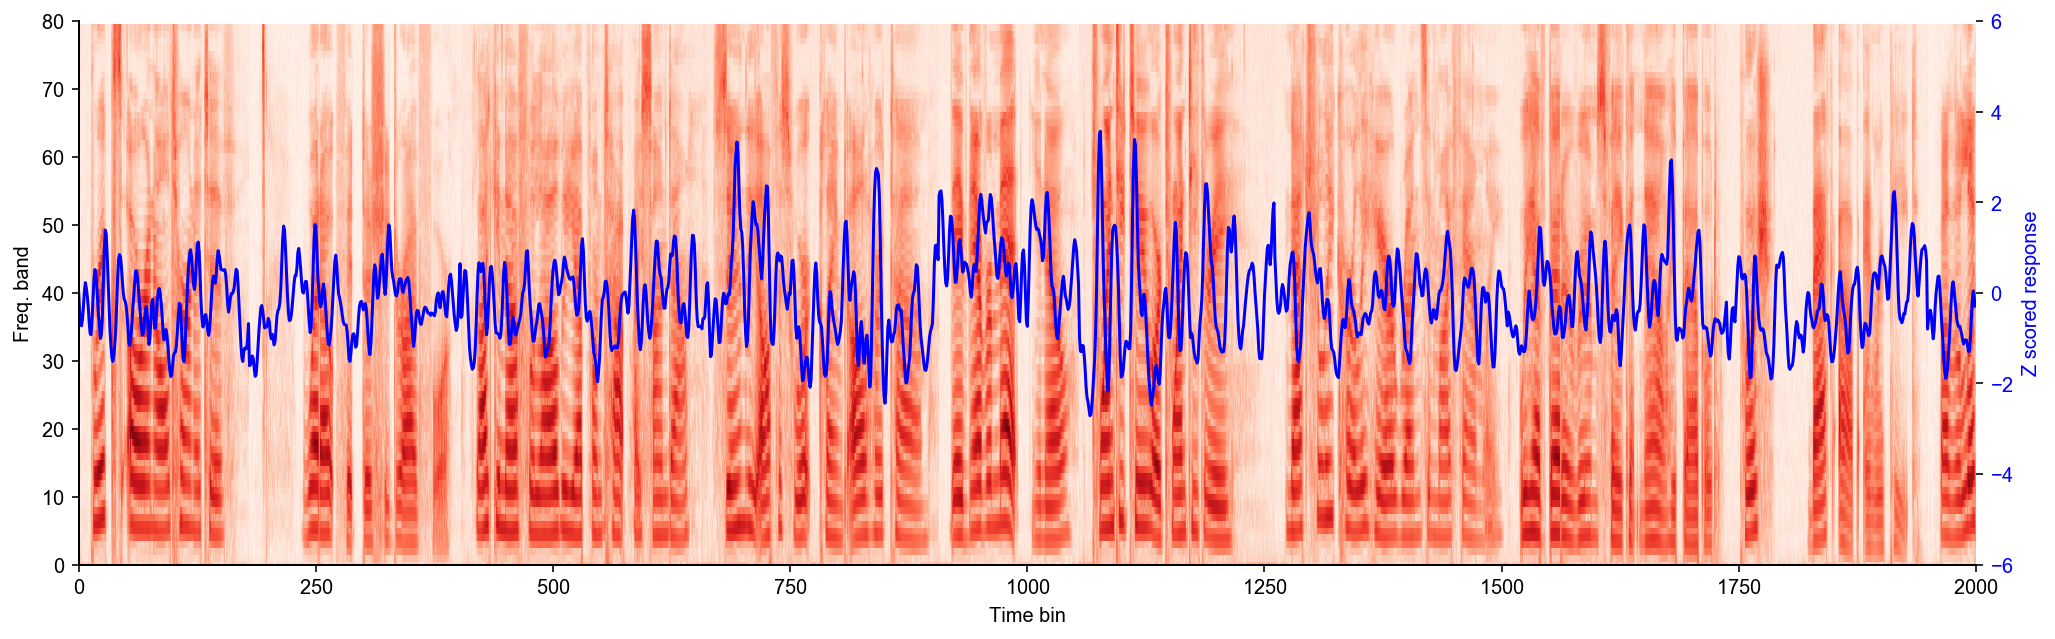

In [83]:
print(raw.info['ch_names'])
picks = mne.pick_channels(ch_names=['Cz'], include=[])
print(picks)
chan_to_plot = picks #10


ntimes = 2000
fig = plt.figure(figsize=(17,5)) # make a figure of size 12 x 8
ax1 = fig.add_subplot(111)
ax1.imshow(stim[:ntimes,:].T, cmap = cm.Reds, aspect='auto') # I transposed the matrix so time is on the x axis
#ax1.plot(stim[:ntimes,:].sum(axis=1), 'r')
plt.xlabel('Time bin')
ax1.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
ax1.set_ylabel('Freq. band')
ax1.set_xlim(0,ntimes)
ax1.set_ylim(0,stim.shape[1])
ax1.axis([0, ntimes, 0, stim.shape[1]])
#ax1.set_ylim(0,400)

# Plot the response overlayed (with a separate y axis scaled appropriately)
ax2 = ax1.twinx()
ax2.plot(resp[:ntimes,chan_to_plot], 'b') 
ax2.set_ylabel('Z scored response', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
ax2.set_xlim(0,ntimes);
ax2.set_ylim(-6, 6)


## Create delay matrices

We now have the prerequisite matrices to perform our regression. If we want to include any time delays, we set up a stacked matrix of our stimulus at different time delays. This actually has a special name -- it's called a [Toeplitz matrix](http://en.wikipedia.org/wiki/Toeplitz_matrix)). As a toy example, say we have a spectrogram with 3 frequencies and n time points.  Our stacked delay matrix would look something like this:

$$
\begin{bmatrix}
                x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0 & 0 & 0& \ldots & 0 \\
                x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0 & 0 & 0& \ldots & 0 \\
                x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0 & 0 & 0& \ldots & 0 \\
                0 & x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0 & 0& \ldots & 0 \\
                0 & x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0 & 0& \ldots & 0 \\
                0 & x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0 & 0& \ldots & 0 \\
                0 & 0 & x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0& \ldots & 0 \\
                0 & 0 & x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0& \ldots & 0 \\
                0 & 0 & x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0& \ldots & 0 \\
                \vdots & \vdots & \vdots & \vdots & \vdots & \ldots & \vdots & \vdots  & \ldots & 0 \\
                0 & \ldots & 0 & 0 & x_{1,1} & \ldots & x_{1,n-2} & x_{1,n-1} & x_{1,n} & \vdots \\
                0 & \ldots & 0 & 0 & x_{2,1} & \ldots & x_{2,n-2} & x_{2,n-1} & x_{2,n} & \vdots \\
                0 & \ldots & 0 & 0 & x_{3,1} & \ldots & x_{3,n-2} & x_{3,n-1} & x_{3,n} & \vdots \\
                0 & \ldots & 0 & 0 & 0 & x_{1,1} & \ldots & x_{1,n-2} & x_{1,n-1} & x_{1,n} \\
                0 & \ldots & 0 & 0 & 0 & x_{2,1} & \ldots & x_{2,n-2} & x_{2,n-1} & x_{2,n} \\
                0 & \ldots & 0 & 0 & 0 & x_{3,1} & \ldots & x_{3,n-2} & x_{3,n-1} & x_{3,n}
            \end{bmatrix}.
$$

In [84]:
#stim = np.atleast_2d(stim.sum(axis=1))
#stim = stim.T
print(stim.shape)

# First, choose the number of delays to use (remember this is in bins)
delay_time = 0.5 # In seconds, how far back in the past to look (more delays = more time, more weights to fit, slower)
delays = np.arange(np.floor(delay_time*fs), dtype=np.int) 
#delays = [0] # Fit only the instantaneous model
print("Delays:", delays)

# z-score the stimulus (if not a binary matrix, otherwise comment out)
zscore_stim = 1
if zscore_stim:
    zstim = zs(stim)
else:
    zstim = stim

nt,ndim = zstim.shape # you could also replace all instances of "stim" here with "phnstim"
dstims = make_delayed(zstim, delays = delays)

print("Stimulus matrix is now %d time points by %d features (should be # original features \
(%d) x # delays (%d))"%(dstims.shape[0], dstims.shape[1], stim.shape[1], len(delays)))

(100322, 80)
Delays: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Stimulus matrix is now 100322 time points by 4000 features (should be # original features (80) x # delays (50))


## Look at delayed stimulus matrix

Here I'll plot only a subset of the delayed matrix so you can see its structure. Again, this is transposed so that time is on the x axis. Red lines are shown so you can appreciate the small shifts of the matrices as a function of delay.

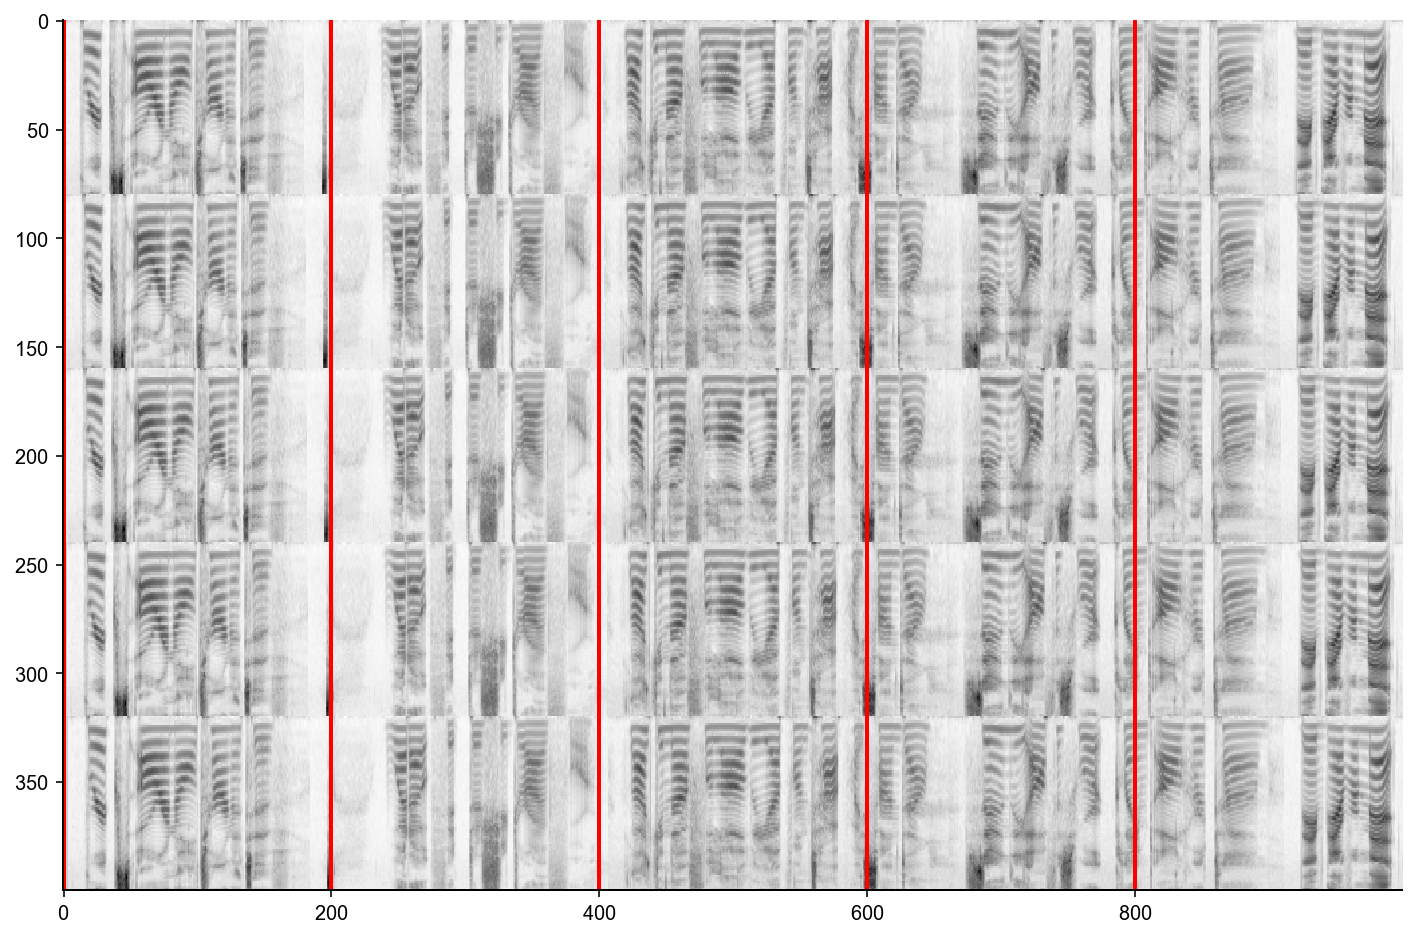

In [85]:
fig, axes = plt.subplots(figsize=(12,8))
plt.imshow(dstims[:1000,:400].T, cmap = cm.Greys, aspect='auto')
plt.gca().xaxis.grid(b=True, which='major', color='r', linestyle='-', linewidth=2)

Here is the whole thing for comparison (still only the first 1000 time points, otherwise this plot is unwieldy.)  The delay structure is much easier to see here, but the fine structure of the individual spectrograms is gone.

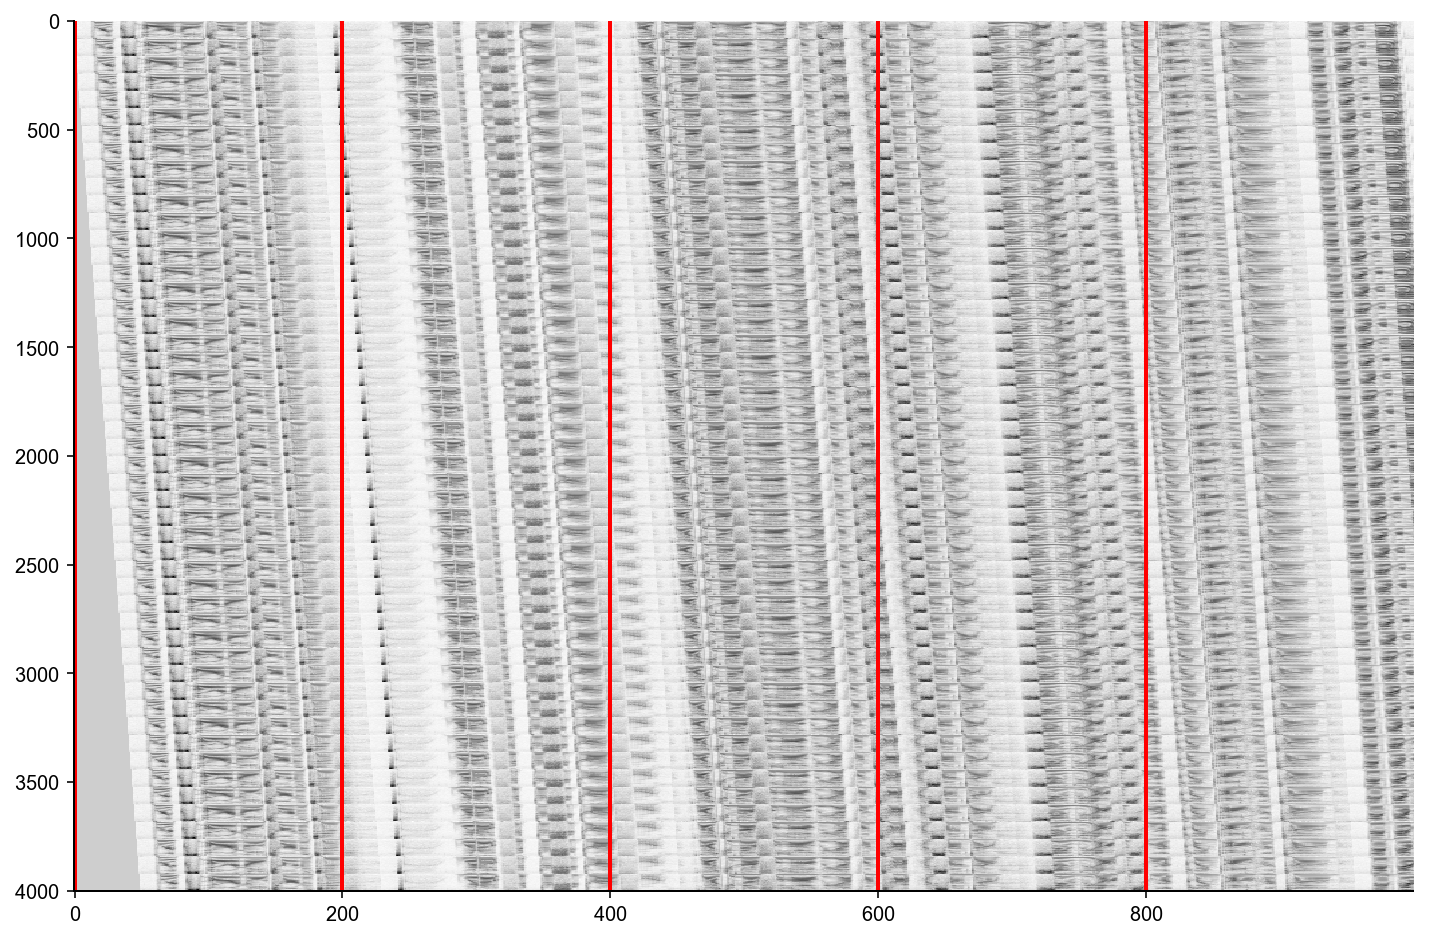

In [86]:
fig, axes = plt.subplots(figsize=(12,8))
plt.imshow(dstims[:1000,:].T, cmap = cm.Greys, aspect='auto')
plt.gca().xaxis.grid(b=True, which='major', color='r', linestyle='-', linewidth=2)

## Setting up the regression models - cross validation

Now that we have this stacked delay matrix, we split the data into chunks for cross validation -- 80% of the data is used for training, and 20% for our final validation.  It is good practice to try different partitions of the data for training and validation to determine the stability of your solution and to get bounds on the correlation coefficients.

In [87]:
# Training indices (the first 80% of the data)
train_inds = np.arange(np.int(nt*0.8))
# Validation indices (the last 20% of the data)
val_inds = np.arange(np.int(nt*0.8),nt)

print(dstims.shape)
# Create matrices for cross validation
tStim = dstims[train_inds,:]
tResp = resp[train_inds,:]
vStim = dstims[val_inds,:]
vResp = resp[val_inds,:]

(100322, 4000)


## Covariance matrix

In most STRF analyses, we must normalize by autocorrelations in the stimulus (frequencies that always appear together, or temporal correlations that occur as a result of smoothly varying signals).  We do this by calculating the covariance of the delayed stimulus.  This will tell us which frequencies/features covary with one another in our stimulus, and how they covary across time (that is, is "f" often followed by "aa" 10 ms later?)

In [88]:
# Calculate covariance matrix for training data
dtype = np.single
covmat = np.array(np.dot(tStim.astype(dtype).T, tStim.astype(dtype)))

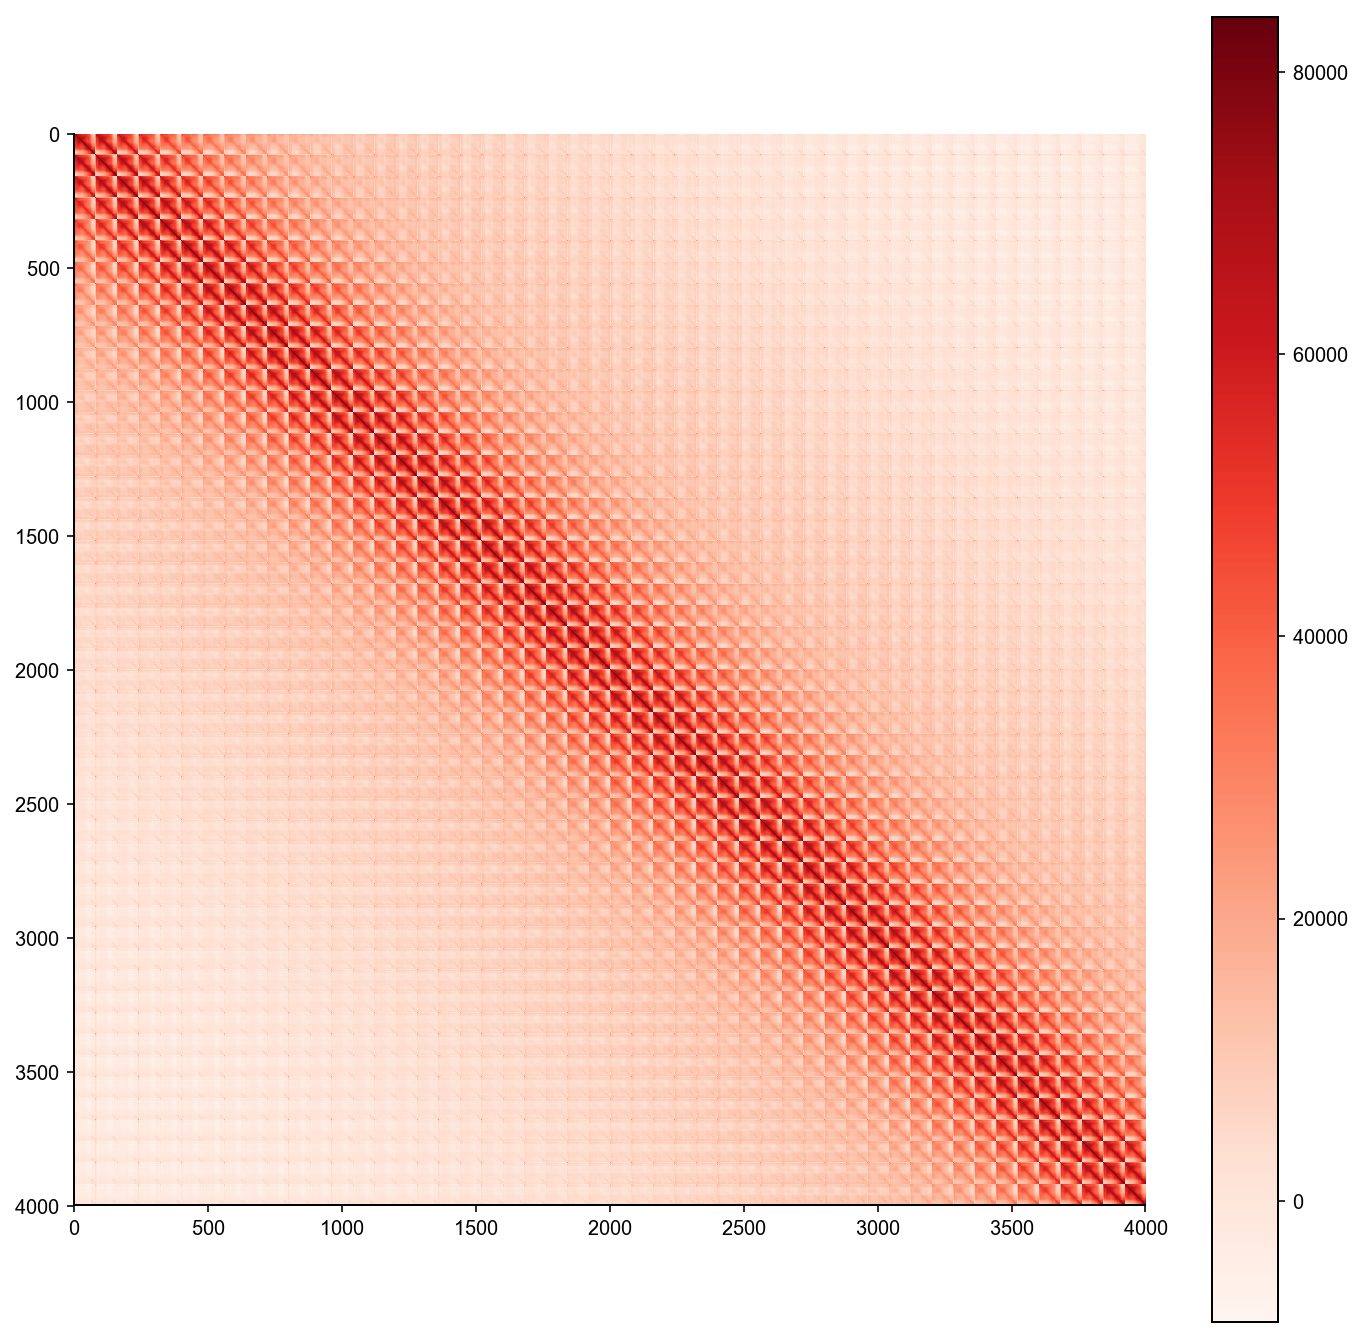

In [89]:
# Show covariance matrix
plt.figure(figsize=(12,12))
plt.imshow(covmat, cmap=cm.Reds)
plt.colorbar()

In [90]:
# For logging compute times, debug messages
import logging
logging.basicConfig(level=logging.DEBUG) 

alphas = np.hstack((0,np.logspace(2,8,15)))
nalphas = len(alphas)
use_corr = True # Use correlation between predicted and validation set as metric for goodness of fit
single_alpha = True # Use the same alpha value for all electrodes (helps with comparing across sensors)
nboots = 3 # How many bootstraps to do. (This is number of times you take a subset of the training data to find the best ridge parameter)
chunklen = np.int(len(delays)*4) # We will randomize the data in chunks 
nchunks = np.floor(0.2*tStim.shape[0]/chunklen).astype('int')

nchans = tResp.shape[1] # Number of electrodes/sensors


wt, corrs, valphas, allRcorrs, valinds, pred, Pstim = bootstrap_ridge(tStim, tResp, vStim, vResp, 
                                                                      alphas, nboots, chunklen, nchunks, 
                                                                      use_corr=use_corr,  single_alpha = single_alpha, 
                                                                      use_svd=False, 
                                                                      joined=[np.array(np.arange(nchans))])

INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing Eigenvalue decomposition...


Cmode = False
Number of time points is greater than the number of features
Rstim shape (not cmode): 
(64257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 64257) (64257, 256)


INFO:ridge_corr:Training: alpha=0.000, mean corr=0.08349, max corr=0.57034, over-under(0.20)=43
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.08461, max corr=0.57274, over-under(0.20)=44
INFO:ridge_corr:Training: alpha=268.270, mean corr=0.08602, max corr=0.57553, over-under(0.20)=44
INFO:ridge_corr:Training: alpha=719.686, mean corr=0.08848, max corr=0.57992, over-under(0.20)=44
INFO:ridge_corr:Training: alpha=1930.698, mean corr=0.09192, max corr=0.58529, over-under(0.20)=46
INFO:ridge_corr:Training: alpha=5179.475, mean corr=0.09576, max corr=0.59044, over-under(0.20)=48
INFO:ridge_corr:Training: alpha=13894.955, mean corr=0.09948, max corr=0.59439, over-under(0.20)=49
INFO:ridge_corr:Training: alpha=37275.937, mean corr=0.10295, max corr=0.59677, over-under(0.20)=52
INFO:ridge_corr:Training: alpha=100000.000, mean corr=0.10603, max corr=0.59723, over-under(0.20)=52
INFO:ridge_corr:Training: alpha=268269.580, mean corr=0.10820, max corr=0.59451, over-under(0.20)=52
INFO:ridge

Cmode = False
Number of time points is greater than the number of features
Rstim shape (not cmode): 
(64257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 64257) (64257, 256)


INFO:ridge_corr:Training: alpha=0.000, mean corr=0.08015, max corr=0.55498, over-under(0.20)=46
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.08092, max corr=0.55640, over-under(0.20)=46
INFO:ridge_corr:Training: alpha=268.270, mean corr=0.08191, max corr=0.55813, over-under(0.20)=48
INFO:ridge_corr:Training: alpha=719.686, mean corr=0.08373, max corr=0.56099, over-under(0.20)=48
INFO:ridge_corr:Training: alpha=1930.698, mean corr=0.08656, max corr=0.56467, over-under(0.20)=49
INFO:ridge_corr:Training: alpha=5179.475, mean corr=0.09032, max corr=0.56858, over-under(0.20)=51
INFO:ridge_corr:Training: alpha=13894.955, mean corr=0.09484, max corr=0.57222, over-under(0.20)=51
INFO:ridge_corr:Training: alpha=37275.937, mean corr=0.09993, max corr=0.57512, over-under(0.20)=52
INFO:ridge_corr:Training: alpha=100000.000, mean corr=0.10493, max corr=0.57636, over-under(0.20)=54
INFO:ridge_corr:Training: alpha=268269.580, mean corr=0.10878, max corr=0.57398, over-under(0.20)=55
INFO:ridge

Cmode = False
Number of time points is greater than the number of features
Rstim shape (not cmode): 
(64257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 64257) (64257, 256)


INFO:ridge_corr:Training: alpha=0.000, mean corr=0.07668, max corr=0.53103, over-under(0.20)=43
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.07742, max corr=0.53316, over-under(0.20)=43
INFO:ridge_corr:Training: alpha=268.270, mean corr=0.07836, max corr=0.53573, over-under(0.20)=44
INFO:ridge_corr:Training: alpha=719.686, mean corr=0.08011, max corr=0.53996, over-under(0.20)=45
INFO:ridge_corr:Training: alpha=1930.698, mean corr=0.08279, max corr=0.54553, over-under(0.20)=45
INFO:ridge_corr:Training: alpha=5179.475, mean corr=0.08633, max corr=0.55155, over-under(0.20)=50
INFO:ridge_corr:Training: alpha=13894.955, mean corr=0.09063, max corr=0.55694, over-under(0.20)=50
INFO:ridge_corr:Training: alpha=37275.937, mean corr=0.09538, max corr=0.56081, over-under(0.20)=51
INFO:ridge_corr:Training: alpha=100000.000, mean corr=0.09972, max corr=0.56252, over-under(0.20)=52
INFO:ridge_corr:Training: alpha=268269.580, mean corr=0.10276, max corr=0.56111, over-under(0.20)=52
INFO:ridge

Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Predicting responses for predictions set..


In [91]:
print(allRcorrs.shape)
print(alphas.shape)

(16, 256, 3)
(16,)


Correlation matrix shape: (16, 256, 3)
10
[12 12 10  9  9 12 15  7  8 12 11 13  9  9 15 15 13  9  8  8  8  9 14  3
  3 15 13 10 10 11 12 12 12  9  9  8  8 11 12 10 13 13 15 10  9 10 12  9
 13 10 10  9  9  9 10 15 15  8 15 15 10  9 13 14 11  9  9 10  8 14 11 15
 15 15  0 12 10  8  9 11 11  9  9  9 11 13 12  0  0  0  0 15 10 15 15 12
 11  8  8  8  9 11 12 15 15  0 10 15 13 15  9  9 11  9  8  8  8  9 11 13
  1 15 11 10 11 11 10 15 15 10  9  8  9  8 11 13 11 15 15 11 11 10 10 10
  9 15  9  9 10 10 13 15 15 15 10 15  0  9  9  9 14 15 10 13  9 10 15 15
 14  3  0  9  6  8  9 11  5  7 15 15 12 10 10 15  8  4 15  8 10  8  4  8
  7  7 15 15 13 10 11 15 12  9  8  8  8  9 11  9 13 12 12 13 13  9  9 10
  9 10  4  0  7 15 14 15  0 14 12 12 13 12 10  8 10  9  4 10 15 15 12 15
 15 13 13 12 13 15  0 10  0  9 15 15 15 14  6  9]


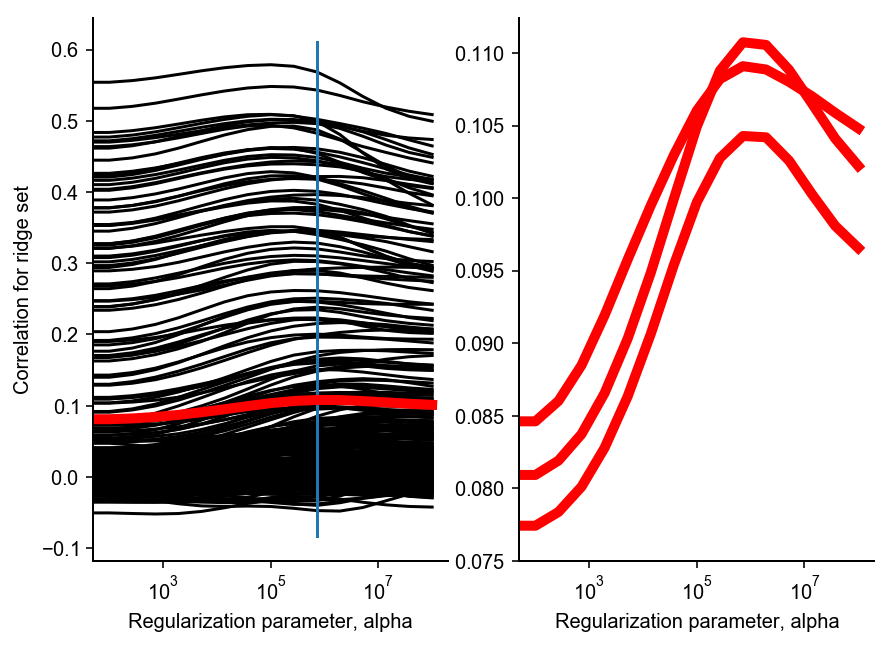

In [92]:
print("Correlation matrix shape:", allRcorrs.shape)

# Find the best alpha value to determine which regularization parameter should be used
best_alpha_overall = allRcorrs.mean(2).mean(1).argmax() # Find the best alpha overall
best_alphas_indiv = allRcorrs.mean(2).argmax(0) # Find the best alpha for each channel separately
print(best_alpha_overall)
print(best_alphas_indiv)

# Plot correlations vs. alpha regularization value
fig=plt.figure(figsize=(7,5))
fig.clf()
plt.subplot(1,2,1)
plt.plot(alphas,allRcorrs.mean(2),'k')
plt.gca().set_xscale('log')

# Plot the best average alpha
plt.plot([alphas[best_alpha_overall], alphas[best_alpha_overall]],[plt.ylim()[0],plt.ylim()[1]])
plt.plot(alphas,np.array(allRcorrs.mean(2)).mean(1),'r',linewidth=5)
plt.xlabel('Regularization parameter, alpha')
plt.ylabel('Correlation for ridge set')

plt.subplot(1,2,2)
plt.plot(alphas,np.array(allRcorrs).mean(1),'r',linewidth=5)
plt.xlabel('Regularization parameter, alpha')
plt.gca().set_xscale('log')


In [93]:
from ridge.ridge import eigridge

# Get weights for all alphas (this is normally not returned by bootstrap_ridge, and is just shown
# for illustrative purposes)
all_wts = []
for alpha in alphas:
    print("Fitting model for alpha=%.3g"%(alpha))
    wt = eigridge(tStim, tResp, alpha)
    all_wts.append(wt)

awt=np.array(all_wts)

INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=0
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=100
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=268
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=720
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=1.93e+03
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=5.18e+03
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=1.39e+04
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=3.73e+04
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=1e+05
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=2.68e+05
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=7.2e+05
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=1.93e+06
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=5.18e+06
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=1.39e+07
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=3.73e+07
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Doing Eigenvalue decomposition on the full stimulus matrix...


Fitting model for alpha=1e+08
Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(80257, 4000)
Covmat shape: 
(4000, 4000)
(4000, 4000) (4000, 80257) (80257, 256)


INFO:ridge_corr:Computing weights


## Calculating performance on the validation set

Next, we need to calculate the predicted response to our validation set for our assessment of model performance.  Normally we would only do this for the best alpha found in the previous step, but here we will calculate all STRFs for all channels and all alphas so we can compare the correlations later.

In [94]:
print("Calculating predicted response to validation set")
wt_array = np.dstack(awt)
print(wt_array.shape)
vPred = [ [ vStim.dot(wt_array[:,ch,alph]) for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vPred = np.array(vPred)

Calculating predicted response to validation set
(4000, 256, 16)


Calculating correlations on validation set
Done calculating correlations
Correlation matrix shape:  (16, 256)


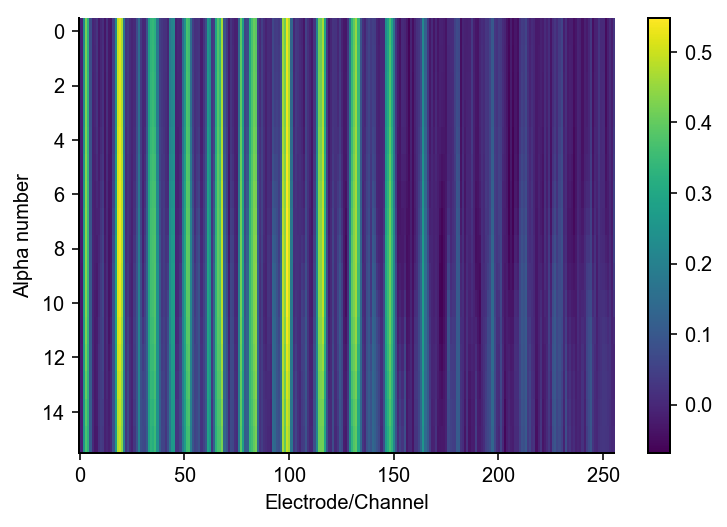

In [95]:
print("Calculating correlations on validation set")
vcorr  = [ [ np.corrcoef(vPred[alph][ch], vResp[:,ch])[0,1] for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vcorr = np.array(vcorr)
print("Done calculating correlations")
print("Correlation matrix shape: ", vcorr.shape)

plt.imshow(vcorr, aspect='auto')
plt.xlabel('Electrode/Channel')
plt.ylabel('Alpha number')
plt.colorbar()

## Plotting predicted vs. actual responses

Best electrode is channel 5 with r= 0.1330109353266447
Prediction matrix shape:  (16, 64, 85684)
Response matrix shape:  (85684, 64)


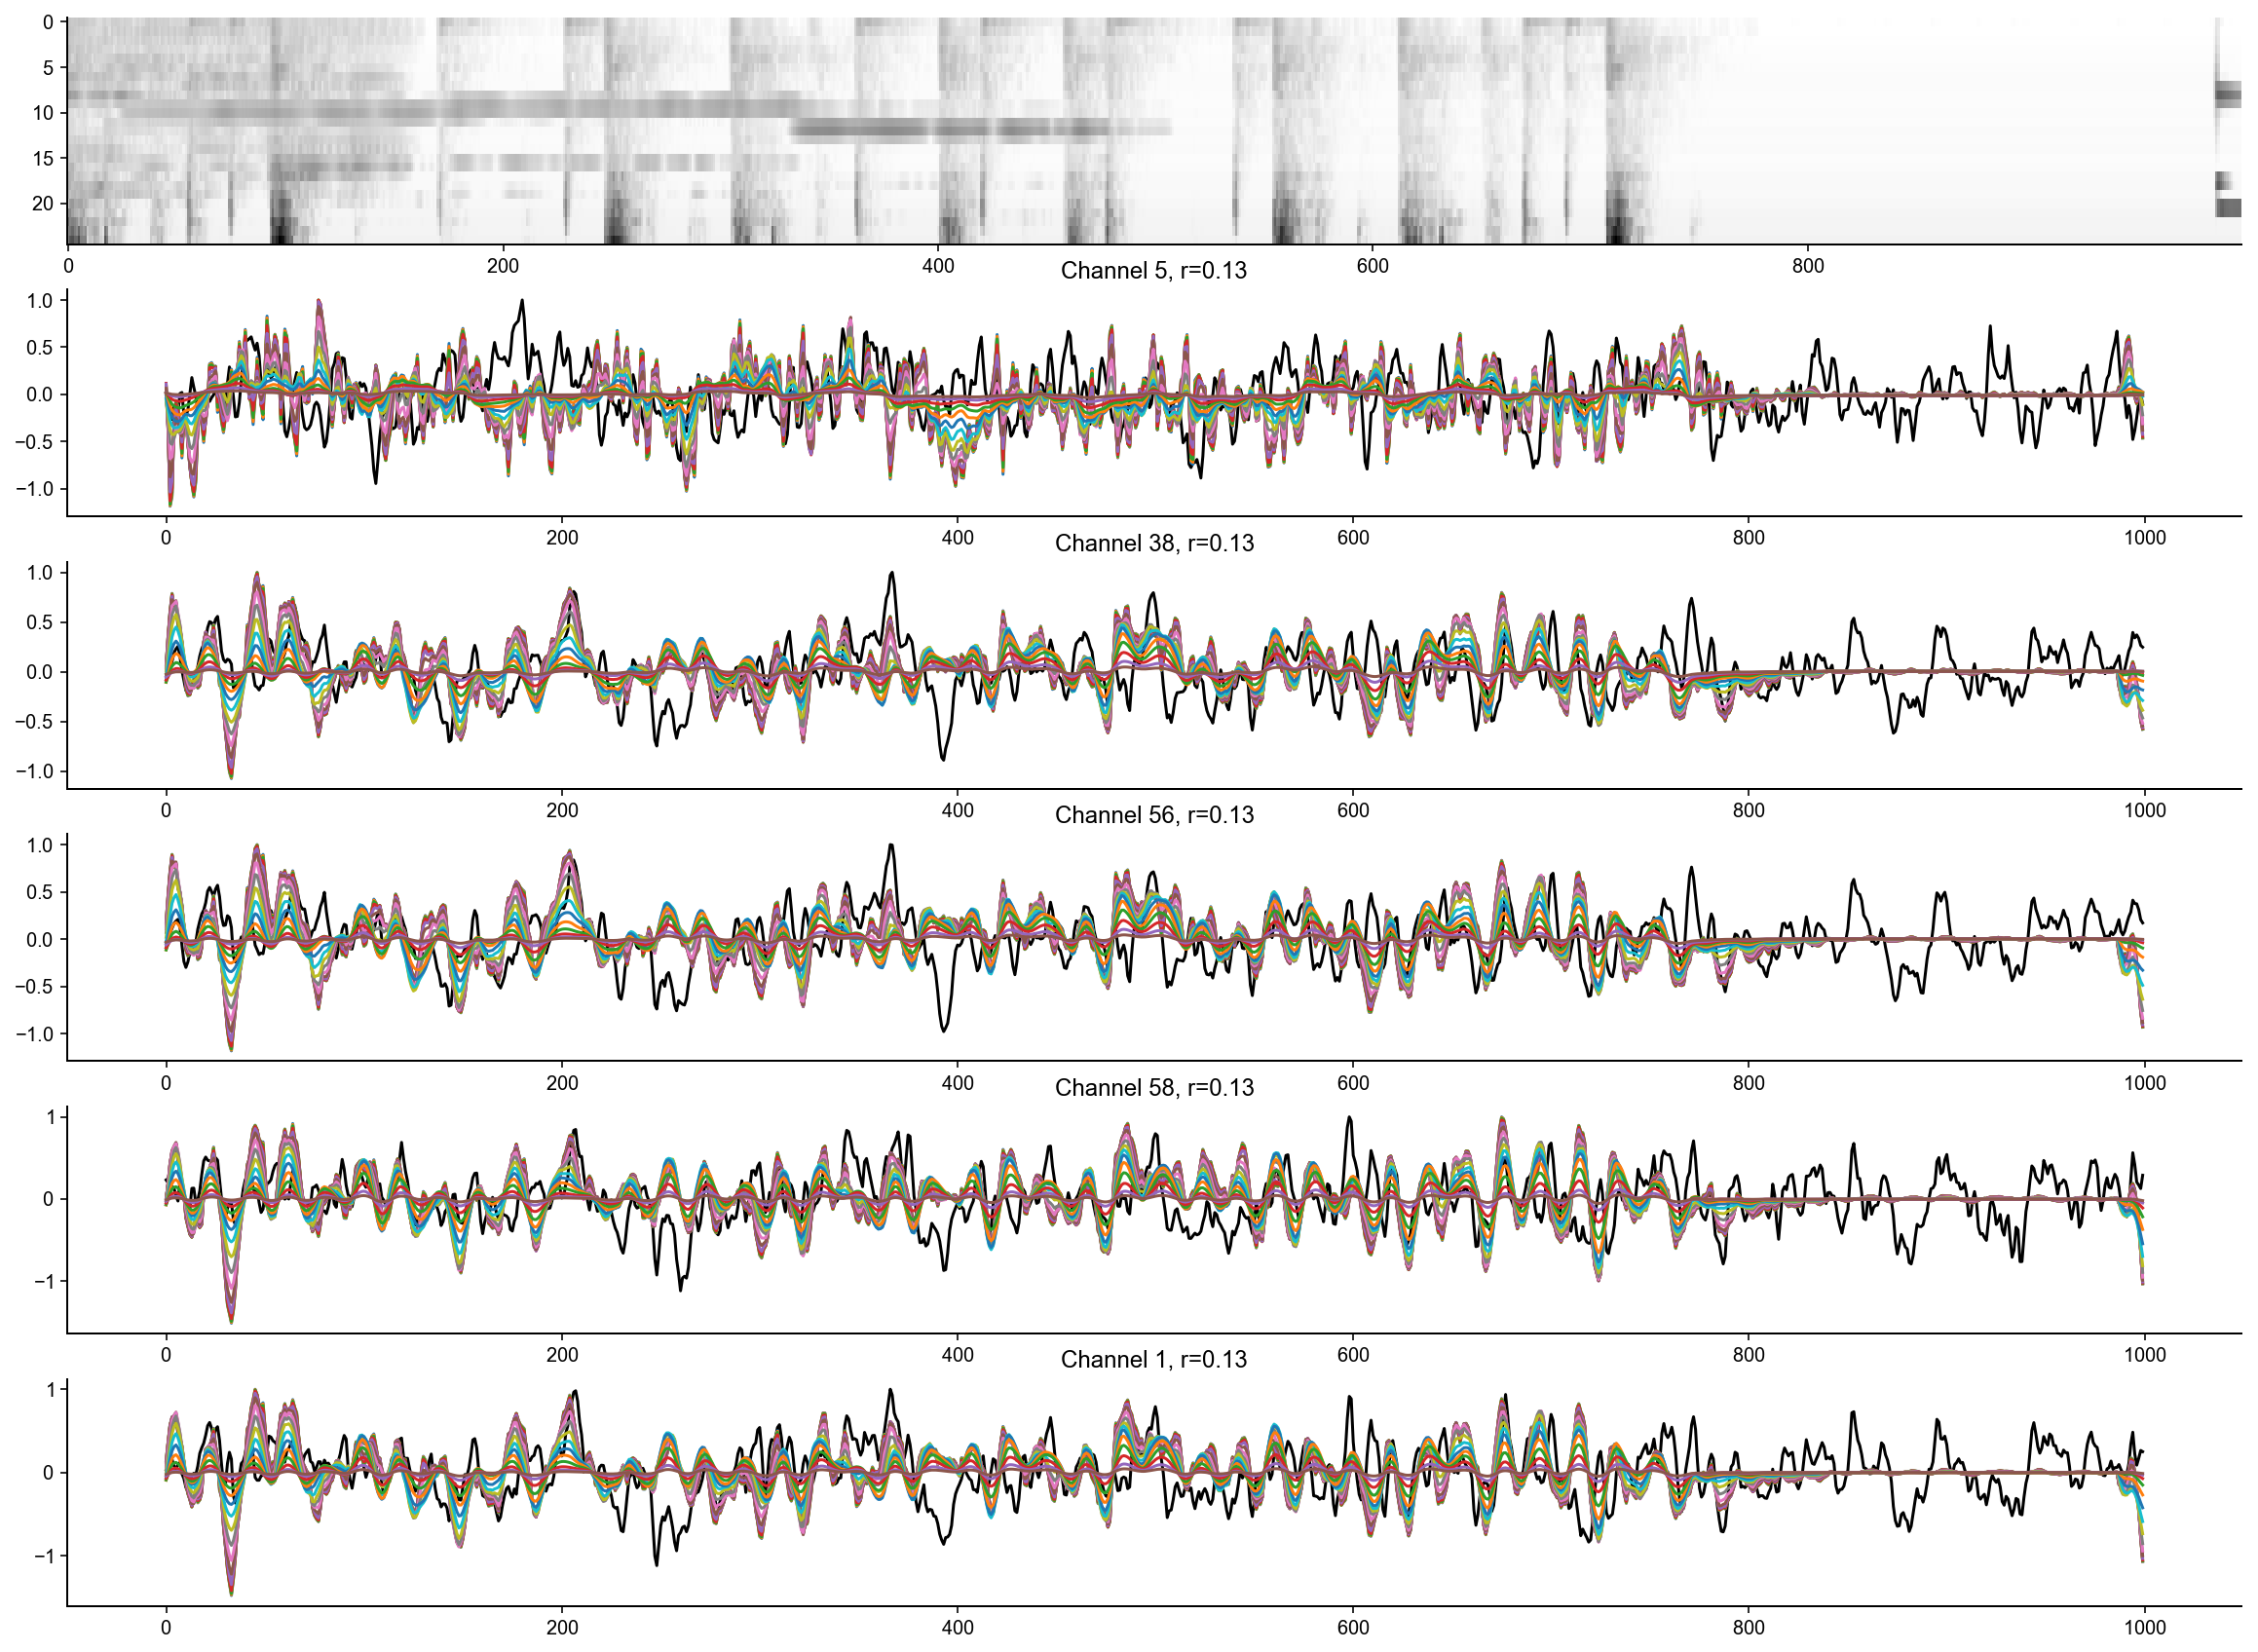

In [64]:
# Sort channels by highest validation correlation and plot the response predicted by the STRF 
# overlayed on the actual activity 
vcorr[np.isnan(vcorr)]=0
sorted_chans = vcorr.mean(0).argsort() # sort validation correlations by highest mean correlation across alpha value
best_chan = sorted_chans[-1]
print("Best electrode is channel", best_chan, "with r=", vcorr[:,best_chan].mean())

# Plot predictions vs. actual response
print("Prediction matrix shape: ", vPred.shape)
print("Response matrix shape: ", vResp.shape)

fig = plt.figure(figsize=(20,15))
plt.subplot(6,1,1)
plt.imshow(vStim[:1000,0:stim.shape[1]].T, aspect='auto', cmap=cm.Greys)
ax.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom

for i in np.arange(5):
    # Get the predicted neural response 
    prediction = vPred[:,sorted_chans[-i],:1000].T
    prediction = prediction/prediction.max() # Rescale to max
    
    actual_resp = vResp[:1000,sorted_chans[-i]]
    actual_resp = actual_resp/actual_resp.max(0) # Rescale to max
    
    plt.subplot(6,1,i+2)
    plt.plot(actual_resp,'k')
    # Plot one trace for each alpha
    for a in np.arange(nalphas):
        plt.plot(prediction[:,a].T)
    
    plt.title('Channel %d, r=%2.2f'%(sorted_chans[-(i+1)], vcorr[:,sorted_chans[-(i+1)]].mean()))
    plt.axis('tight')

## Visualizing the STRF filters

Here we will show the STRF filters we've derived for each channel.  These filters show which spectrotemporal features of the stimulus best predict an increase or decrease in the observed neural activity.

(1600, 64, 16)


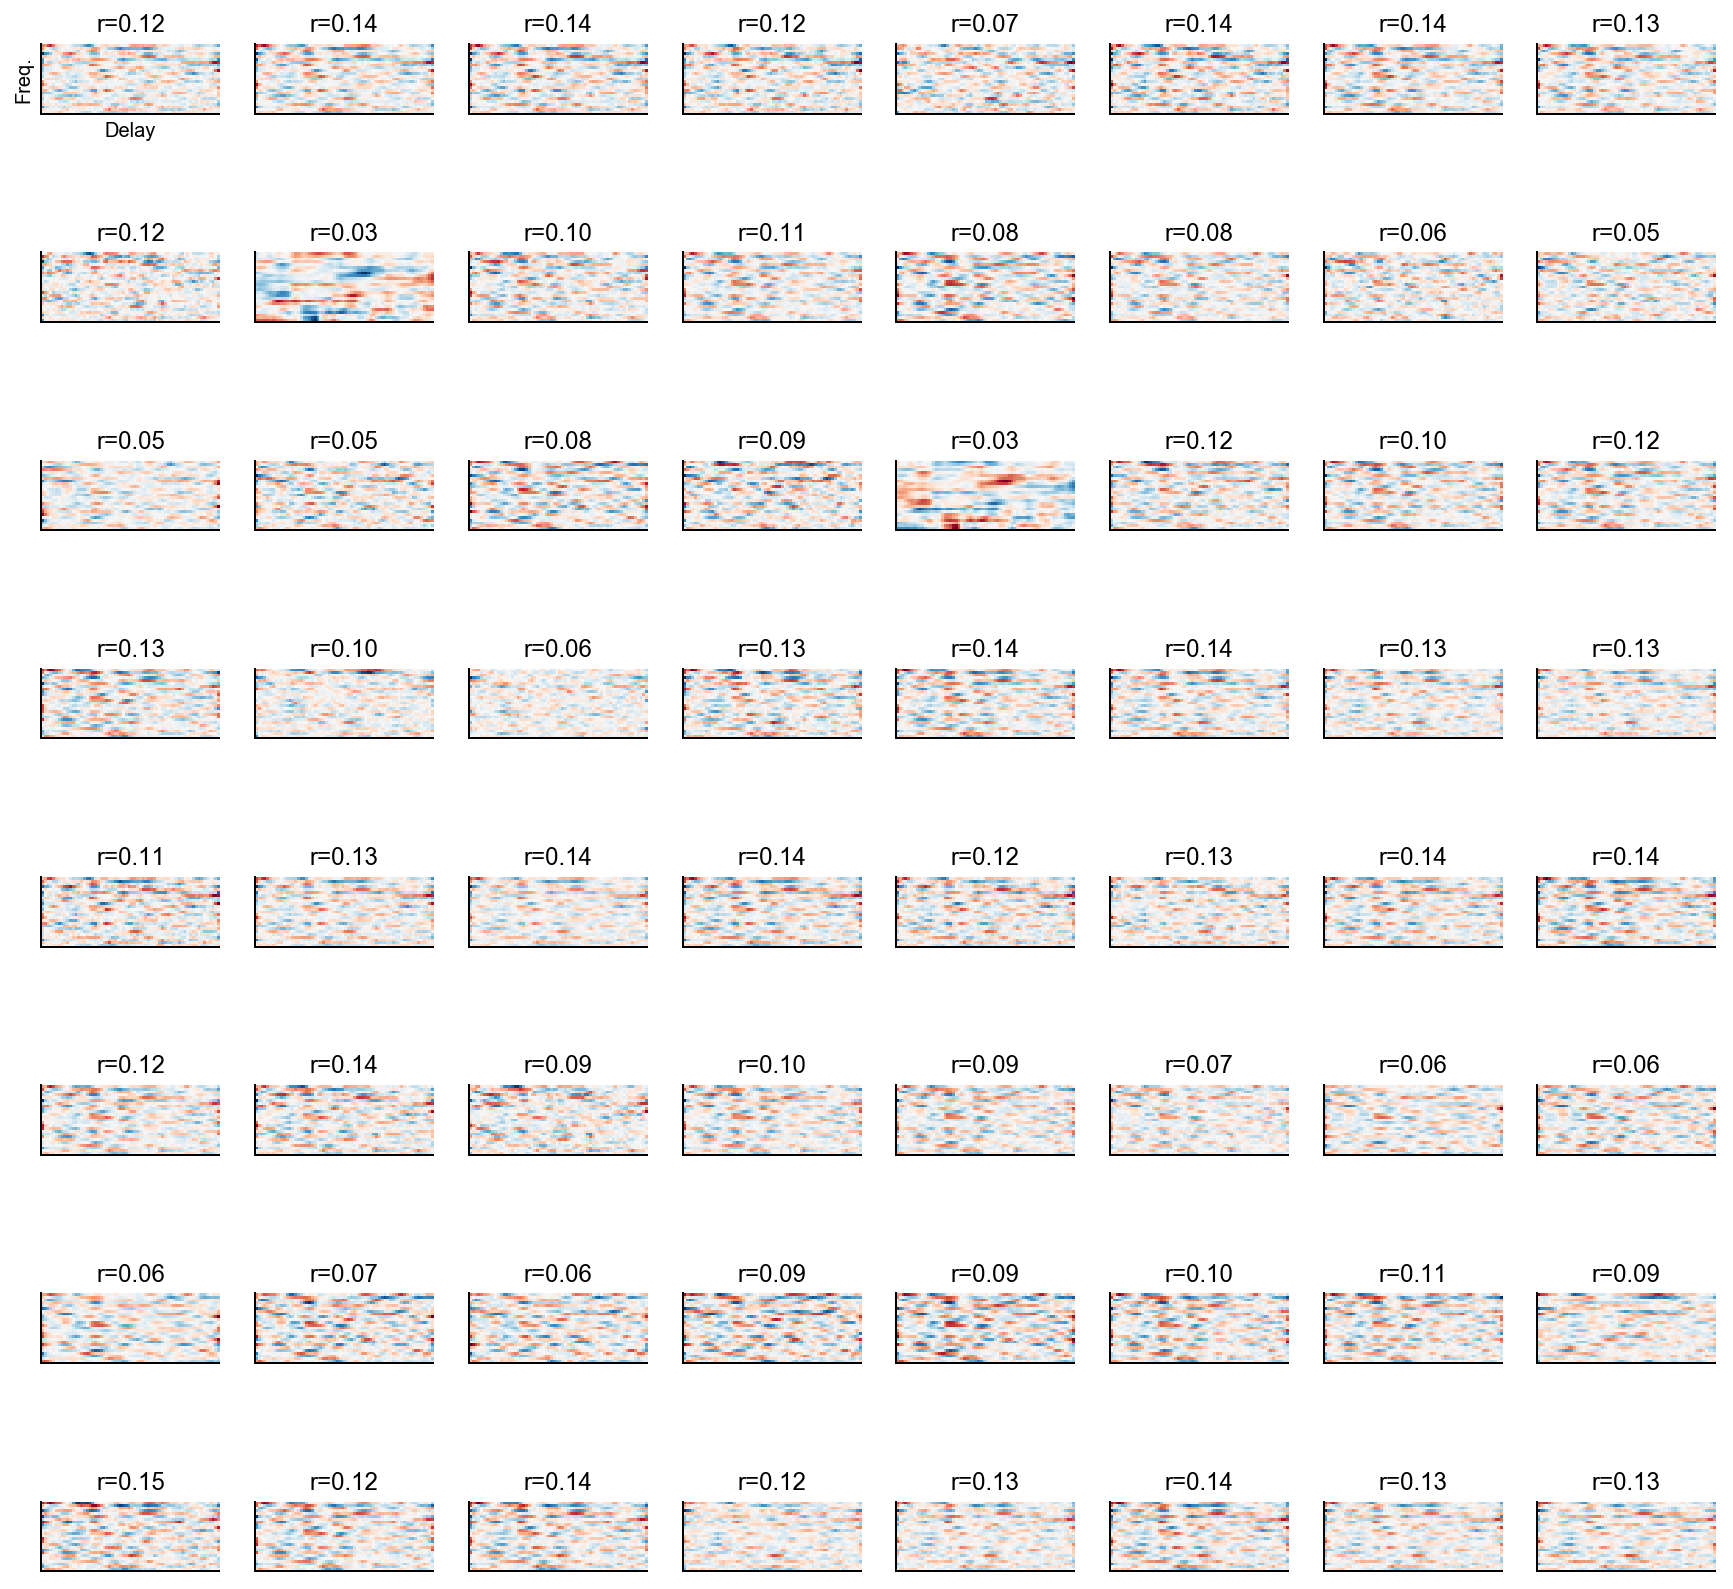

In [66]:
# Plot all of the STRFs, using a separate regularization parameter for each (whichever gives the best performance)
if nchans>4:
    fsize=(15,15)
    nrow = np.sqrt(nchans)
    ncol = np.ceil(nchans/nrow)
else:
    fsize=(6,3)
    nrow = 1
    ncol = nchans

fig = plt.figure(figsize=fsize)
print(wt_array.shape)
# Use separate regularization parameters for each STRF
#nchans = 256
for c in np.arange(nchans):
    ax = fig.add_subplot(nrow,ncol,c+1)
    strf = wt_array[:,c,best_alphas_indiv[c]].reshape(len(delays),-1)
    smax = np.abs(strf).max()
    #smax = np.abs(wt_array).max()*0.5
    plt.imshow(strf.T, vmin=-smax, vmax=smax, cmap = cm.RdBu_r)
    plt.title('r=%2.2f'%(vcorr[best_alphas_indiv[c], c]))
    if c==0:
        plt.xlabel('Delay')
        plt.ylabel('Freq.')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #title('alpha=%3.3g'%(alphas[best_alphas_indiv[c]]))
    #colorbar()

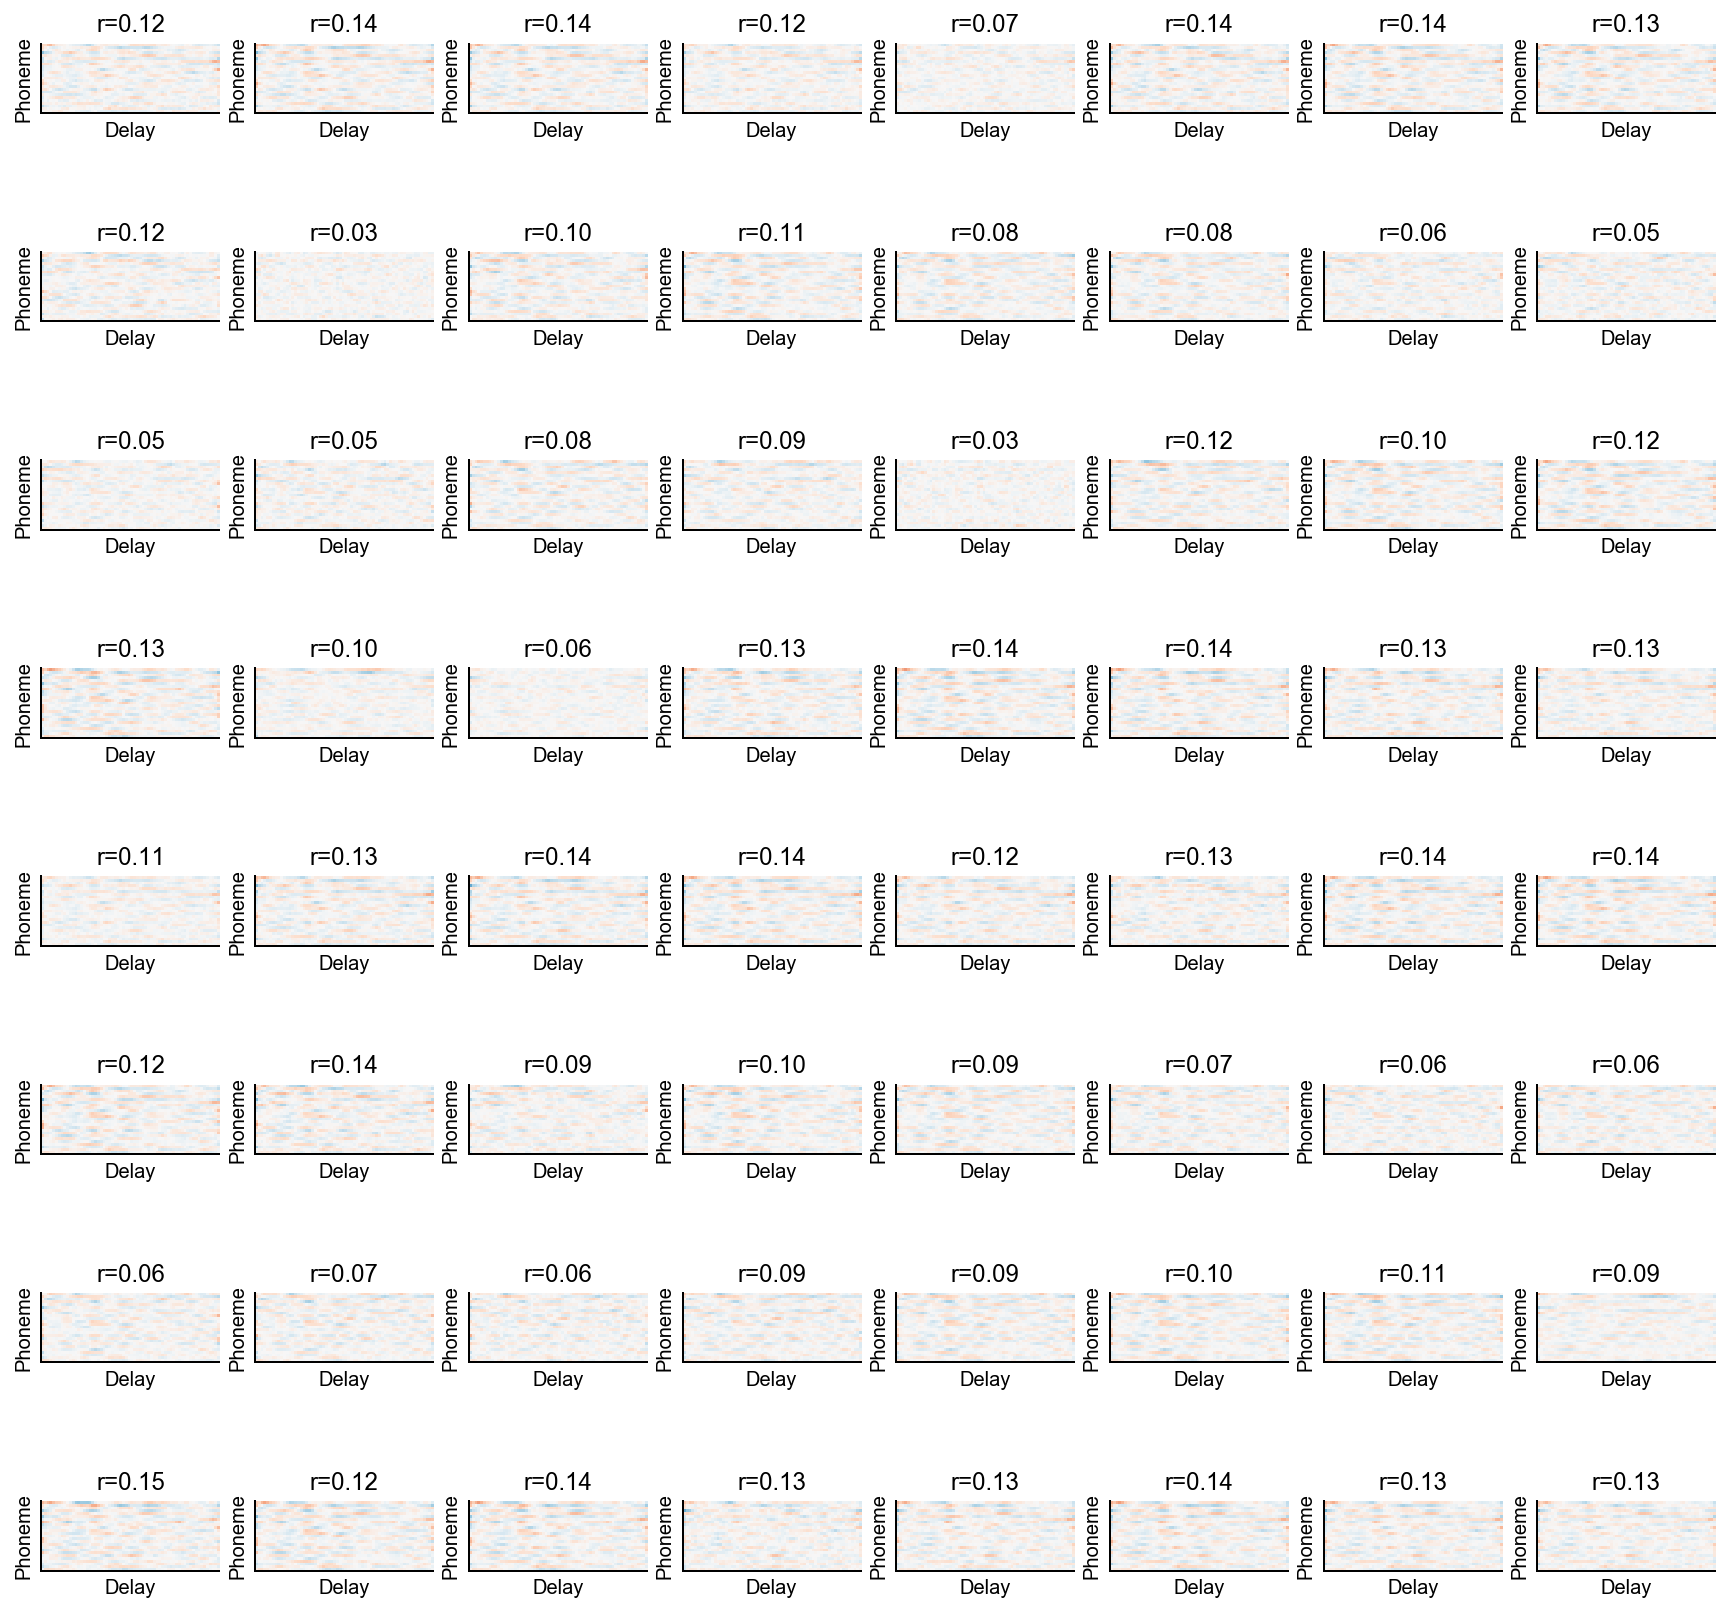

In [70]:
# Use the same regularization parameters for each STRF
fig = plt.figure(figsize=fsize)
for c in np.arange(nchans):
    ax = fig.add_subplot(nrow,ncol,c+1)
    strf = wt_array[:,c,best_alpha_overall].reshape(len(delays),-1)
    smax = np.abs(wt_array).max()
    plt.imshow(strf.T,vmin=-smax, vmax=smax, cmap = cm.RdBu_r)
    plt.title('r=%2.2f'%(vcorr[best_alpha_overall, c]))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    plt.xlabel('Delay')
    plt.ylabel('Phoneme')
    #colorbar()

## How does the selection of $\alpha$ affect the observed STRF filters?##

It is important to choose a range of $\alpha$ values and determine which yield the best predictions on held out data, since the regularization parameter itself can affect the structure of your STRF.

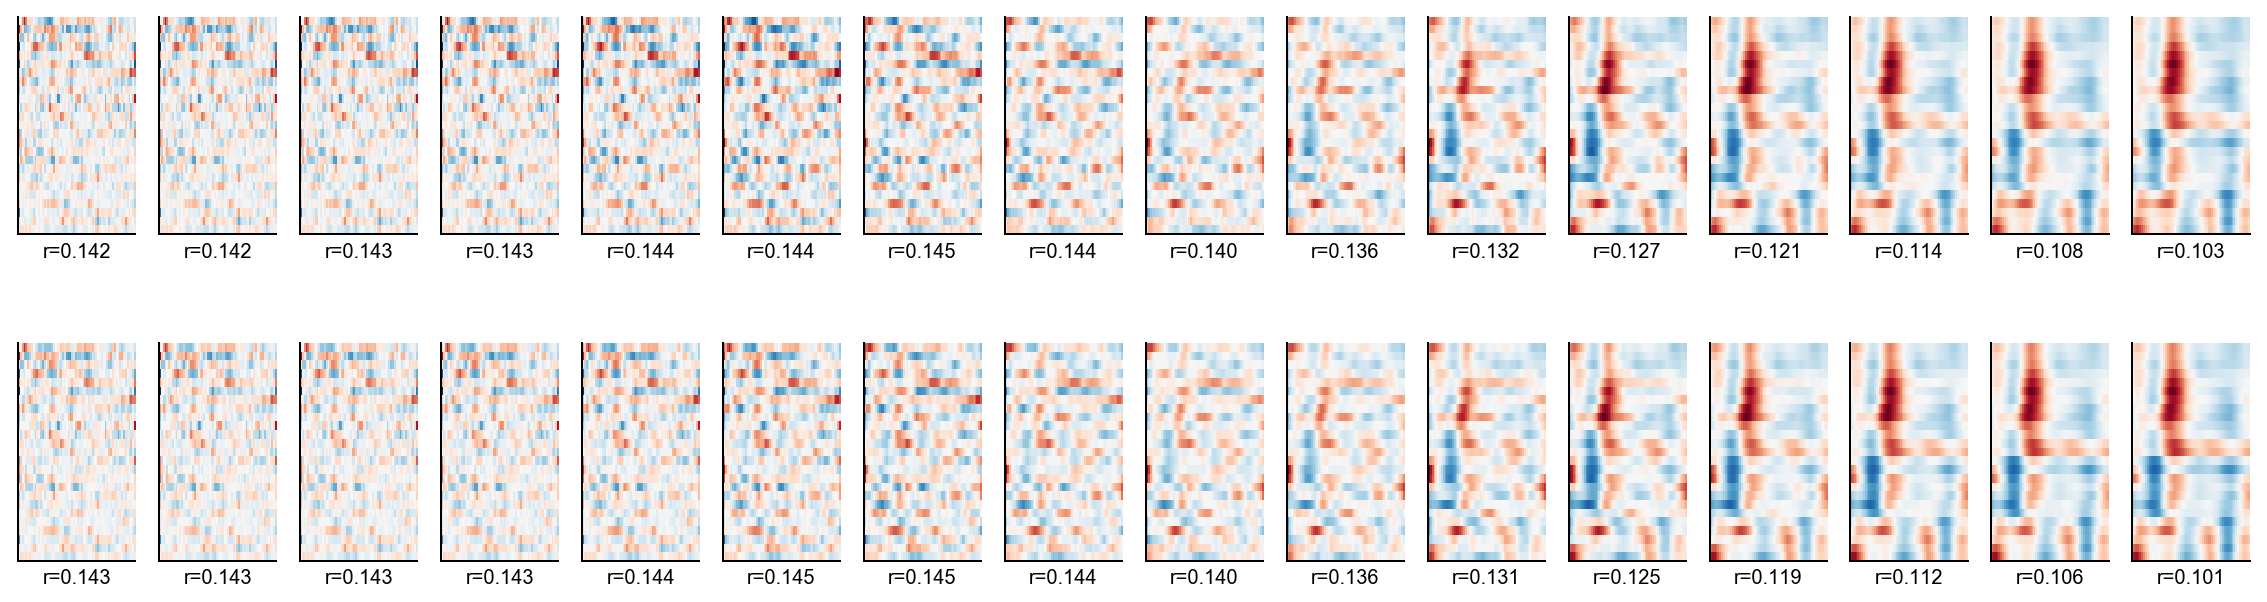

In [72]:
# Show how regularization parameter changes STRFs
fig = plt.figure(figsize=(20,5))
fig.clf()
best_nchans = 2
axes = [fig.add_subplot(best_nchans,len(alphas),ii+1) for ii in range((len(alphas))*best_nchans)]
best_strf_inds = np.array(vcorr).mean(0).argsort()[::-1]
p = 0
for c in np.arange(best_nchans): # loop through the best channels
    ch = best_strf_inds[c]
    for a in np.arange(len(alphas)): # loop through the alpha regularization parameter
        strf = wt_array[:,ch,a].reshape(len(delays),-1)
        smax = np.abs(strf).max()
        axes[p].imshow(strf.T,vmin=-smax, vmax=smax, cmap = cm.RdBu_r, aspect='auto') 
        axes[p].xaxis.set_ticks([])
        axes[p].yaxis.set_ticks([])
        #axes[p].set_title('a=%1.1g'%(alphas[a]),fontsize=10)
        axes[p].set_xlabel('r=%2.3f'%(np.array(vcorr)[a,ch]))
        p+=1

fig.subplots_adjust(hspace=.5)
        

In [78]:
import tables
# Save the weights file
def save_table_file(filename, filedict):
    """Saves the variables in [filedict] in a hdf5 table file at [filename].
    """
    with tables.open_file(filename, mode="w", title="save_file") as hf:
        for vname, var in filedict.items():
            hf.create_array("/", vname, var)

wtfile = 'wts.hf5'
save_table_file(wtfile, dict(wts = wt, corrs = allRcorrs, vcorrs = corrs, fs = fs, delays = delays, alphas = alphas, valphas = valphas))